## 케라스 콜백과 텐서보드를 사용한 딥러닝 모델 검사와 모니터링

### 콜백을 사용하여 모델의 훈련 과정 제어하기
* 콜백을 사용하는 몇 가지 사례
    * **모델 체크포인트 저장**: 훈련하는 동안 어떤 지점에서 모델의 현재 가중치를 저장한다.
    * **조기 종료**(early stopping): 검증 손실이 더 이상 향상되지 않을 때 훈련을 종지한다.(물론 훈련하는 동안 얻은 가장 좋은 모델을 저장한다.)
    * **훈련하는 동안 하이퍼파라미터 값을 동적으로 조정한다**: 옵티마이저의 학습률 같은 경우이다.
    * **훈련과 검증 지표를 로그에 기록하거나 모델이 학습한 표현이 업데이터될 때마다 시가화한다.**: 앞서 보았던 케라스의 진행 표시줄(progress bar)이 하나의 콜백이다.

#### ModelCheckpoint와 EarlyStopping 콜백
```
import keras

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_acc',
        patience=1,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='my_model.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

model.fit(
    x, y,
    epochs=10,
    batch_size=32,
    callbacks=callbacks_list,
    validation_data=(x_val, y_val)
)
```

#### ReduceLROnPlateau 콜백
```
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
    )
]

model.fit(
    x, y,
    epochs=10,
    batch-size=32,
    callbacks=callbacks_list,
    validation_data=(x_val, y_val)
)
```

#### 자신만의 콜백 만들기
* `keras.callbacks.Callback` 클래스를 상속받아 구현한다.
* `on_epoch_begin` - 각 에포크가 시작할 때 호출
* `on_epoch_end` - 각 에포크가 끝날 때 호출
* `on_batch_begin` - 각 배치 처리가 시작되기 전에 호출
* `on_batch_end` - 각 배치 처리가 끝난 후에 호출
* `on_train_begin` - 훈련이 시작될 때 호출
* `on_train_end` - 훈련이 끝날 때 호출
* 이 메서드들은 모두 logs 매개변수와 함께 호출된다.
* `self.model`: 콜백을 호출하는 모델 객체
* `self.validation_data`: fit() 메서드에 전달된 검증 데이터
---
```
import keras
import numpy as np

class ActivationLogger(keras.callbacks.Callback):
    def set_model(self, model):
        self.model = model
        layer_outputs = [layer.output for layer in model.layers]
        self.activations_model = keras.models.Model(model.input, layer_outputs)

    def on_epoch_end(self, epoch, logs=None):
        if self.validation_data in None:
            raise RuntimeError('Requires validation_data.')

        validation_sample = self.validation_data[0][0:1]
        activations = self.activations_model.predict(validation_sample)
        f = open('activations_at_epoch_' + str(epoch) + '.npz', 'wb')
        np.savez(f, activations)
        f.close()
```

### 텐서보드 소개: 텐서플로의 시각화 프레임워크
* 훈련하는 동안 측정 지표를 시각적으로 모니터링한다
* 모델 구조를 시각화한다.
* 활성화 출력과 그래디언트의 히스토그램을 그린다.
* 3D로 임베딩을 표현한다.

In [5]:
import keras
from keras import layers
from keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 2000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = keras.models.Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len, name='embed'))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embed (Embedding)           (None, 500, 128)          256000    
                                                                 
 conv1d_2 (Conv1D)           (None, 494, 32)           28704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 98, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                

In [6]:
!mkdir my_log_dir

A subdirectory or file my_log_dir already exists.


In [7]:
callbacks = [
    keras.callbacks.TensorBoard(
        log_dir='my_log_dir',
        histogram_freq=1,
        embeddings_freq=1,
    )
]
history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/20
157/157 [==============================] - 6s 7ms/step - loss: 0.6019 - acc: 0.6647 - val_loss: 0.4720 - val_acc: 0.8222
Epoch 2/20
157/157 [==============================] - 1s 6ms/step - loss: 0.4454 - acc: 0.8507 - val_loss: 0.4507 - val_acc: 0.8618
Epoch 3/20
157/157 [==============================] - 1s 6ms/step - loss: 0.3978 - acc: 0.8805 - val_loss: 0.4594 - val_acc: 0.8716
Epoch 4/20
157/157 [==============================] - 1s 6ms/step - loss: 0.3582 - acc: 0.8982 - val_loss: 0.6098 - val_acc: 0.8570
Epoch 5/20
157/157 [==============================] - 1s 6ms/step - loss: 0.3034 - acc: 0.9227 - val_loss: 0.6805 - val_acc: 0.8494
Epoch 6/20
157/157 [==============================] - 1s 6ms/step - loss: 0.2716 - acc: 0.9408 - val_loss: 0.6256 - val_acc: 0.8676
Epoch 7/20
157/157 [==============================] - 1s 6ms/step - loss: 0.2242 - acc: 0.9545 - val_loss: 0.6362 - val_acc: 0.8656
Epoch 8/20
157/157 [==============================] - 1s 6ms/step - loss: 0.

In [8]:
!tensorboard --logdir=my_log_dir

^C


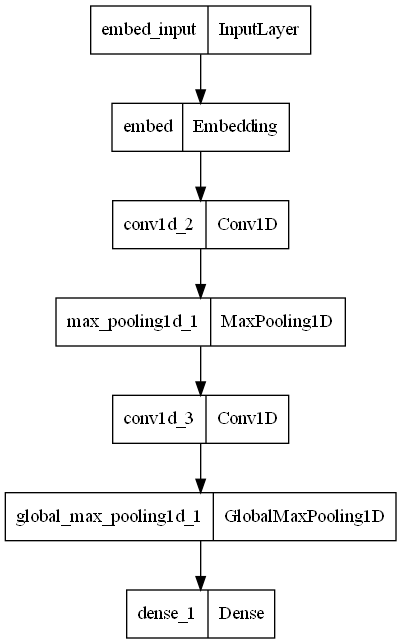

In [9]:
from keras.utils import plot_model

plot_model(model, to_file='model.png')

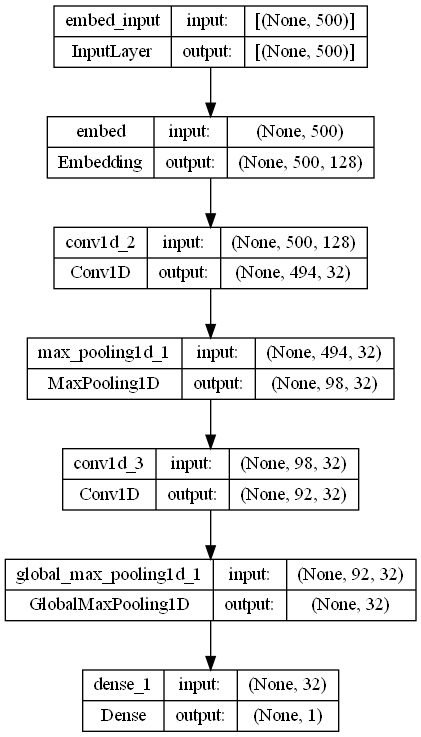

In [11]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, to_file='model.png')

### 정리
* 케라스 콜백은 훈련하는 동안 모델을 모니터링하고 모델 상태를 바탕으로 자동으로 작업을 수행하는 손쉬운 방법이다.
* 텐서플로를 사용하면 텐서보드를 이용하여 모델 상황을 브라우저에서 시각화할 수 있다. 테라스 모델에서는 TensorBoard 콜백을 통해 사용한다.

## 모델의 성능을 최대로 끌어올리기
### 고급 구조 패턴
* 정규화와 깊이별 분리 합성곱.
* 고성능 심층 컨브넷을 만들 때 유용하다.

#### 배치 정규화
* **정규화**(normalization)는 머신 러닝 모델에 주입되는 샘플들을 균일하게 만드는 광범위한 방법이다.
* 이 방법은 모델이 학습하고 새로운 데이터에 잘 일반화되도록 돕는다.
* `normalized_data = (data - np.mean(data, axis=...)) / np.std(data, axis=...)`
* 배치 정규화는 훈련하는 동안 평균과 분산이 바뀌더라도 이에 적응하여 데이터를 정규화한다.
* 배치 정규화의 주요 효과는 잔차 연결과 매우 흡소호게 그래디언트의 전파를 도와주는 것이다.
* 결국 더 깊은 네트워크를 구성할 수 있다.
* BatchNormalization 층은 일반적으로 합성곱이나 완전 연결 층 다음에 사용한다.
```
conv_model.add(layers.Conv2D(32, 3, activation='relu'))
conv_model.add(layers.BatchNormalization())

dense_model.add(layers.Dense(32, activation='relu'))
dense_model.add(layers.BatchNormalization())
```
* BatchNormalization 클래스에는 정규화할 특성 측을 지정하는 axis 매개변수가 있다.
* 이 매개변수의 기본값은 입력 텐서의 마지막 축을 나타내는 -1이다.
* data_format을 "channels_last"도 하여 Dense, Conv1D, RNN, Conv2D 층을 사용할 때는 맞는 값이다.
* 하지만 data_format을 "channels_first"로 사용하는 경우에는 특성 축이 1이다.

#### 깊이별 분리 합성곱
* Conv2D를 대체하면서 더 가볍고(훈련할 모델 파라미터가 더 적고) 더 빨라(부동 소수 연산이 더 적고) 모델의 성능을 몇 퍼센트 포인트 높일 수 있는 층
* **깊이별 분리 합성곱**(depthwise separable convolution) 층이 하는 일이다.(SeparableConv2D)
* 입력 채널별로 따로따로 공간 방향의 합성골을 수행한다.
```
from keras.models import Sequential, Model
from keras import layers

height = 64
width = 64
channels = 3
num_classes = 10

model= Sequential()
model.add(layers.SeparableConv2D(
    32, 3, 
    activation='relu', 
    input_shape=(height, width, channels,)
))
model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.SeparableConv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.SeparableConv2D(128, 3, activation='relu'))
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
```

### 하이퍼파라미터 최적화
* 가능한 결정 공간을 자동적, 조직적, 규칙적 방법으로 탐색해야 한다.
* 전형적인 하이퍼파라미터 최적화 과정은 다음과 같다.
    1. 일련의 하이퍼파라미터를 (자동으로) 선택한다.
    2. 선택된 하이퍼파라미터로 모델을 만든다.
    3. 훈련 데이터에 학습하고 검증 데이터에서 최종 성능을 측정한다.
    4. 다음으로 시도할 하이퍼파라미터를 (자동으로) 선택한다.
    5. 이 과정을 반복한다.
    6. 마지막으로 테스트 데이터에서 성능을 측정한다.
* 베이지안 최적화(bayesian optimization), 유전 알고리즘(genetic algorithms), 간단한 랜덤 탐색(random search) 등이 있다.
* 하이퍼파라미터를 업데이트하는 것은 매유 어려운 일이다.
    * 피드백 신호를 계산하는 것은 매우 비용이 많이 든다.(이 하이퍼파라미터가 성능이 높은 모델은 만들어 낼까?) 새로운 모델을 만들고 데이터셋을 사용하여 처음부터 다시 훈련해야 한다.
    * 하이퍼파라미터 공간은 일반적으로 분리되어 있는 결정들로 채워진다. 즉 연속적이지 않고 미분 가능하지 않다. 그러므로 하이퍼파라미터 공간에 경사 하겅법을 사용할 수 없다. 그 대신 경사 하강법보다 훨씬 비효율적인 그래디언트-프리(gradient-free) 최적화 기법을 사용해야 한다.

### 모델 앙상블
* **모델 앙상블**(model ensemble)은 가장 좋은 결과를 얻을 수 있는 또 다른 강력한 기법이다.
* 앙상블은 여러 개 다른 모델의 예측을 합쳐서 더 좋은 예측을 만든다.
---
* 분류기 예측을 (앙상블하기 위해) 합치는 가장 쉬운 방법은 추론할 때 나온 예측을 평균 내는 것이다.
```
preds_a = model_a.predict(x_val)
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_val)

final_preds = 0.25 * (preds_a + preds_b + preds_c + preds_d)
```
* 이 방식은 분류기들이 어느 정도 비슷하게 좋을 때 잘 작동한다.
* 분류기 중 하나가 다른 모델보다 월등히 나쁘면 최종 예측은 앙상블에 있는 가장 좋은 분류기만큼 좋지 않을 수 있다.
* 분류기를 앙상블하는 좋은 방법은 검증 데이터에서 학습된 가중치를 사용하여 가중 평균하는 것이다.
* 전형적으로 분류기가 좋을수록 높은 가중치를 가지고 나쁜 분류기일수록 낮은 가중치를 갖는다.
* 좋은 앙상블 가중치를 찾기 위해 랜덤 서치나 넬더-미드(Nelder-Mead) 방법 같는 간단한 최적화 알고리즘을 사용할 수 있다.
```
preds_a = model_a.predict(x_val)
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_val)

final_preds = 0.5 * preds_a + 0.25 * preds_b + 0.1 * preds_c + 0.15 * preds_d
```
* 가중치 (0.5, 0.25, 0.1, 0.15)는 경험적으로 학습되었다고 가정
* 앙상블이 잘 작동하게 만드는 핵심은 분류기의 다양성이다.
* 가능한 최대한 다르면서 촣은 모델을 앙상블해야 한다.
* 일반적으로 매우 다른 구조를 가지거나 다른 종류의 머신 러닝 방법을 말한다.
* 최상의 모델이 얼마나 좋은지보다 앙상블의 후보 모델이 얼마나 다양한지가 중요하다.

### 정리
* 고성능 심층 컨브넷을 만들려면 잔차 연결, 배치 정규화, 갚이별 분리 합성곱을 사용해야 한다. 미래에는 깊이별 분리 합성곱이 일반적인 합성곱을 완전히 대체할 것이다. 애플리케이션이 1D나 2D 또는 3D인지와 상관없이 아주 효율적으로 표현을 학습하기 때문이다.
* 심층 네크워크를 만들 때 많은 하이퍼파라미터와 네트워크 구조를 선택해야 한다. 이 값을이 모여 모델의 성능을 결정한다. 이런 선택을 직관이나 랜엄한 선택에 위존하지 않고 최적의 선택을 찾기 위해 하이퍼파라미터 공간을 조직적으로 탐색하는 것이 좋다.
* 머신 러닝 경연 대회에서 우승하거나 어떤 문제에서 최상의 결과를 얻으려면 대규모로 모델을 앙상블하게 된다. 최적화가 잘된 가중 평균으로 만든 앙상블은 보통 충분히 좋은 결과를 만든다. 다양성이 중요하다는 것을 기억해야 한다. 비슷한 모델을 앙상블하는 것은 거의 쓸모가 없다.

## 요약
* 임의의 층 그래프를 구성하는 모델을 만드는 방법, 층을 재사용하는 방법(가중치 공유), 파이썬 함수 방식으로 모델을 사용하는 방법(모델 템플릿)
* 케라스 콜백을 사용하여 훈련하는 동안 모델을 모니터링하고 모델 상태를 바탕으로 작업을 수행한다.
* 텐서보드를 사용하여 측정 지표, 활성화 출력의 히스토그램, 임테딩 공간을 시각화한다.
* 배치 정규화, 깊이별 분리 합성곱, 잔차 연결
* 하이퍼파라미터 최적화와 모델 앙상블을 사용하는 이유